In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(readr)
library(fixest)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
base_tpv_master = read_csv('base_tpv_master_completa.csv')

Rows: 17669446 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (14): document, tpv_stone, share_tpv_debit, share_tpv_credit, share_tpv...
dbl   (4): tpv_total, municipio, cnae_fiscal_principal, grupo_cnae_fiscal_pr...
date  (1): reference_month

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
base_cadastro_stone = read_csv('base_cadastrados_stone.csv')
base_cadastro_ton = read_csv('base_cadastrados_ton.csv')
base_ativos_stone = read_csv('base_ativos_30d_stone.csv')
base_ativos_ton = read_csv('base_ativos_30d_ton.csv')

ls_doc_cadastro_stone = base_cadastro_stone %>% pull(DocumentNumber)
ls_doc_cadastro_ton = base_cadastro_ton %>% pull(document)
ls_doc_ativos_stone = base_ativos_stone %>% pull(document)
ls_doc_ativos_ton = base_ativos_ton %>% pull(document)

Rows: 7766235 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): DocumentNumber

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 9115588 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): document

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 761324 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): document

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2133260 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimit

In [4]:
base_tpv_master_cadastro = base_tpv_master %>% distinct(document) %>% mutate(cadastro_stone = if_else(document %in% ls_doc_cadastro_stone,1,0),
                              cadastro_ton = if_else(document %in% ls_doc_cadastro_ton,1,0),
                              ativo_30d_stone = if_else(document %in% ls_doc_ativos_stone,1,0),
                               ativo_30d_ton = if_else(document %in% ls_doc_ativos_ton,1,0))

In [5]:
base_tpv_master_cadastro = base_tpv_master_cadastro %>%
  mutate(cadastro_stone = if_else((cadastro_stone == 0 & ativo_30d_stone == 1),1,cadastro_stone),
        cadastro_ton = if_else((cadastro_ton == 0 & ativo_30d_ton == 1),1,cadastro_ton))

In [6]:
base_tpv_master_cadastro %>% filter((cadastro_stone == 1) | (cadastro_ton == 1)) %>% nrow(.)

[1] 1442111

In [7]:
base_tpv_master_cadastro %>% filter(cadastro_stone == 0,cadastro_ton == 0) %>% nrow(.)

[1] 409908

In [8]:
base_tpv_master_cadastro %>% filter(cadastro_stone == 1,cadastro_ton == 0) %>% nrow(.)

[1] 816495

In [9]:
base_tpv_master_cadastro %>% filter(cadastro_stone == 0,cadastro_ton == 1) %>% nrow(.)

[1] 98552

In [10]:
base_tpv_master_cadastro %>% filter(cadastro_stone == 1,cadastro_ton == 1) %>% nrow(.)

[1] 527064

In [11]:
base_tpv_master_cadastro %>% filter((ativo_30d_stone == 1)|(ativo_30d_ton == 1)) %>% nrow(.)

[1] 838914

In [12]:
base_tpv_master_cadastro %>% filter(ativo_30d_stone == 0,ativo_30d_ton == 0) %>% nrow(.)

[1] 1013105

In [13]:
base_tpv_master_cadastro %>% filter(ativo_30d_stone == 1,ativo_30d_ton == 0) %>% nrow(.)

[1] 518632

In [14]:
base_tpv_master_cadastro %>% filter(ativo_30d_stone == 0,ativo_30d_ton == 1) %>% nrow(.)

[1] 315513

In [15]:
base_tpv_master_cadastro %>% filter(ativo_30d_stone == 1,ativo_30d_ton == 1) %>% nrow(.)

[1] 4769

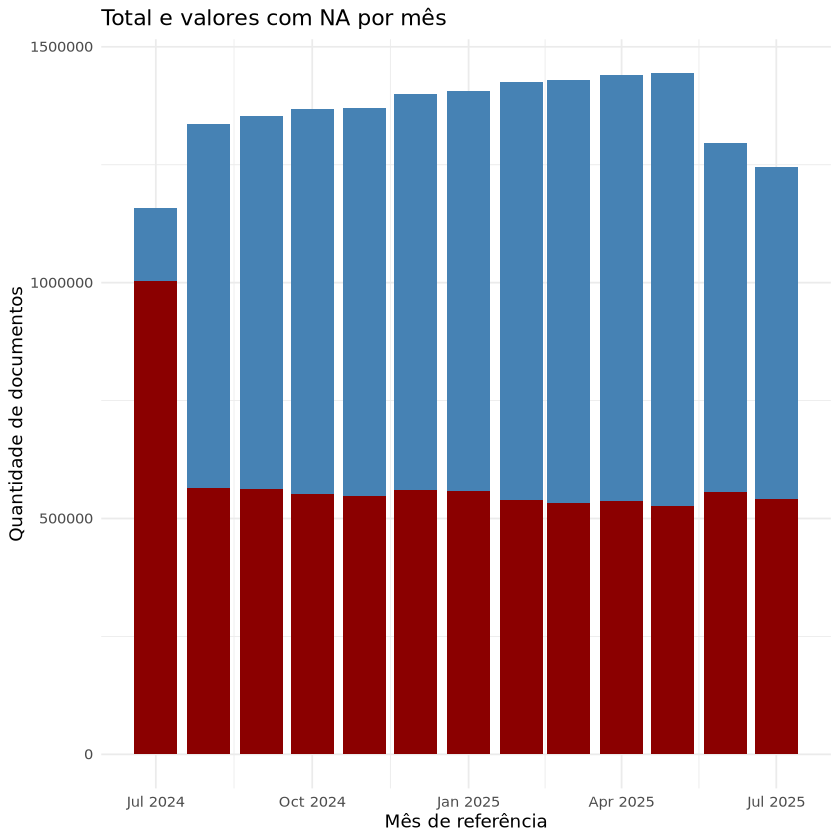

In [16]:
dados_plot <- base_tpv_master %>%
  group_by(reference_month) %>%
  summarise(
    total = length(unique(document)),
    soma_na = sum(is.na(average_ticket_size))
  ) %>%
  mutate(
    nao_na = total - soma_na,              # parte sem NA
    pct_nan = (soma_na / total) * 100
  )

# Converter para formato longo (necessário para gráfico empilhado)
dados_long <- dados_plot %>%
  select(reference_month, soma_na, nao_na) %>%
  tidyr::pivot_longer(cols = c(soma_na, nao_na),
                      names_to = "tipo",
                      values_to = "valor")

# Gráfico de barras empilhadas
ggplot(dados_long, aes(x = reference_month, y = valor, fill = tipo)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Total e valores com NA por mês",
    x = "Mês de referência",
    y = "Quantidade de documentos"
  ) +
  scale_fill_manual(values = c("soma_na" = "darkred", "nao_na" = "steelblue")) +
  theme_minimal() + 
  theme(legend.position = "none")


In [17]:
base_tpv_master = base_tpv_master %>% filter(reference_month > "2024-08-01")  

In [18]:
base_tpv_master_doc_meses = base_tpv_master %>% group_by(document) %>% summarise(total_meses = length(unique(reference_month)))                                            

In [19]:
ls_documentos_11m = base_tpv_master_doc_meses %>% filter(total_meses == 11) %>% pull(document)
base_tpv_master_ = base_tpv_master %>% filter(document %in% ls_documentos_11m)

In [20]:
base_tpv_master_na_ticket = base_tpv_master_ %>% group_by(document) %>% summarise(soma_na = sum(is.na(average_ticket_size)))

In [21]:
ls_documentos_avg = base_tpv_master_na_ticket %>% filter(soma_na < 11) %>% pull(document)
base_tpv_master__ = base_tpv_master_ %>% filter(document %in% ls_documentos_avg)

In [22]:
ls_documentos_credit = base_tpv_master__ %>% group_by(document) %>% summarise(soma_na = sum(is.na(share_tpv_credit))) %>% filter(soma_na < 11) %>% pull(document)
base_tpv_master___ = base_tpv_master__ %>% filter(document %in% ls_documentos_credit)

In [23]:
base_tpv_master___ = base_tpv_master___ %>% mutate(share_tpv_credit = as.numeric(share_tpv_credit),
                             average_ticket_size = as.numeric(average_ticket_size),
                              tpv_total = as.numeric(tpv_total))

In [24]:
base_medias_avg_credit = base_tpv_master___ %>% group_by(document) %>% summarise(media_avg_ticket = mean(average_ticket_size,na.rm=T), media_share_credit = mean(share_tpv_credit,na.rm=T))

In [25]:
base_tpv_master___ = base_tpv_master___ %>% left_join(.,base_medias_avg_credit,by=c('document'))

In [26]:
base_tpv_master___ = base_tpv_master___ %>% mutate(tpv_total_credit = tpv_total*media_share_credit) 

In [27]:
ls_documentos_completos = base_tpv_master___ %>% mutate(tpv_total_credit_menor_1 = if_else(tpv_total_credit < 1,1,0)) %>% group_by(document) %>% summarise(soma_menor_1 = sum(tpv_total_credit_menor_1)) %>% filter(soma_menor_1 == 0) %>% pull(document) 
base_tpv_master____ = base_tpv_master___ %>% filter(document %in% ls_documentos_completos)

In [28]:
base_tpv_master____ = base_tpv_master____ %>% mutate(q = tpv_total_credit/media_avg_ticket) %>% mutate(log_q = log(q))

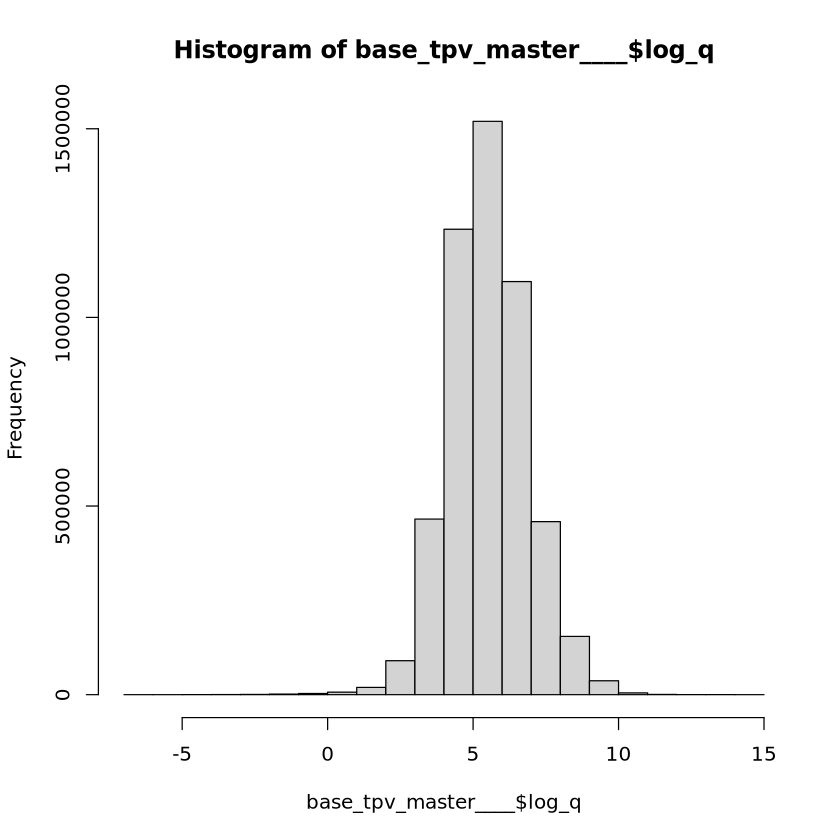

In [29]:
hist(base_tpv_master____$log_q)

In [30]:
base_modelo = base_tpv_master____ %>% select(document,reference_month,tpv_total_credit,log_q,grupo_cnae_fiscal_principal,municipio)

In [31]:
base_analise_modelo = base_modelo %>% distinct(document) %>% mutate(cadastro_stone = if_else(document %in% ls_doc_cadastro_stone,1,0),
                              cadastro_ton = if_else(document %in% ls_doc_cadastro_ton,1,0),
                              ativo_30d_stone = if_else(document %in% ls_doc_ativos_stone,1,0),
                               ativo_30d_ton = if_else(document %in% ls_doc_ativos_ton,1,0))

In [32]:
m1 = feols(log_q ~ 1 | document + reference_month^grupo_cnae_fiscal_principal + reference_month^municipio, base_modelo, fixef.keep_names=T)

NOTES: 66 observations removed because of NA values (Fixed-effects: 66).
       0/11/3,641 fixed-effect singletons were removed (3,652 observations).



In [33]:
summary(m1)

OLS estimation, Dep. Var.: log_q
Observations: 5,087,170
Fixed-effects: document: 462,470,
 reference_month^grupo_cnae_fiscal_principal: 825,
 reference_month^municipio: 54,813
RMSE: 0.375832   Adj. R2: 0.91368

In [34]:
base_modelo$yhat = predict(m1, newdata = base_modelo)         

In [35]:
base_modelo$resid = base_modelo$log_q - base_modelo$yhat

In [36]:
fe_list = fixef(m1)            # lista de vetores por FE
fe_doc  = fe_list$document     # named vector: nomes = níveis de document

df_doc_fe = data.frame(
  document   = names(fe_doc),
  fe_document = as.numeric(fe_doc),
  row.names = NULL)


NOTE: The fixed-effects are not regular, they cannot be straightforwardly interpreted.



In [37]:
base_modelo = base_modelo %>% left_join(.,df_doc_fe,by=c('document'))

In [38]:
base_modelo = base_modelo %>%
  arrange(document, reference_month) %>%
  group_by(document) %>%
  mutate(resid_3m = zoo::rollapply(resid, width = 3, FUN = mean, align = "right", fill = NA, partial = TRUE))


In [39]:
base_modelo_ = base_modelo %>% filter(!is.na(fe_document))

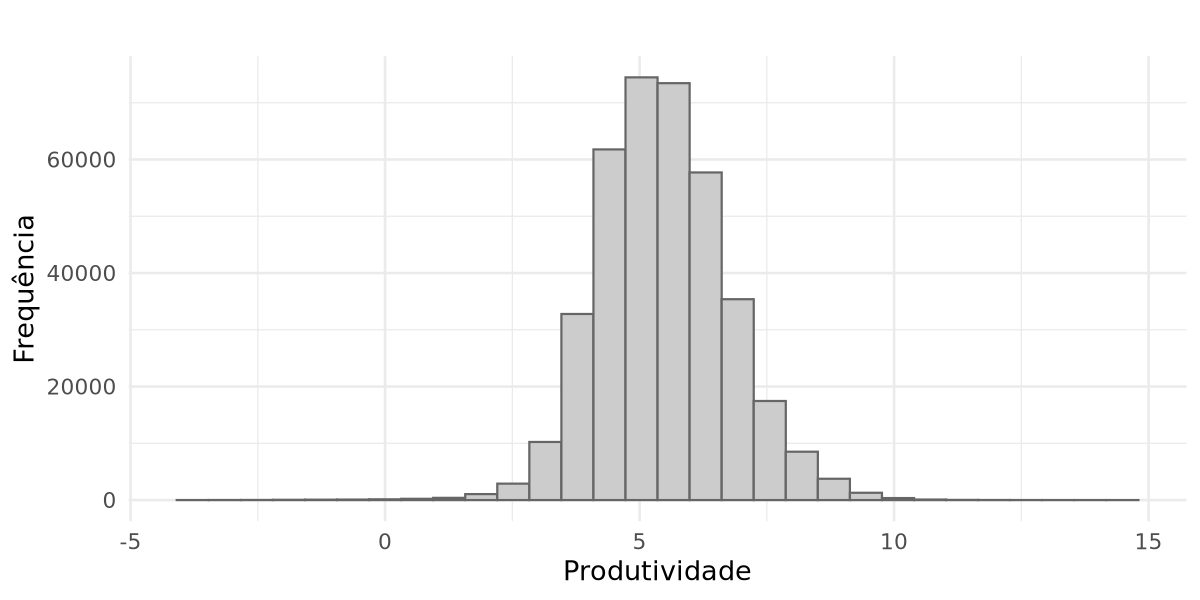

In [40]:
# Define tamanho e resolução padrão dos gráficos
options(repr.plot.width = 8,  # largura em polegadas
        repr.plot.height = 4,  # altura
        repr.plot.res = 150)   # resolução (dpi)

ggplot(data.frame(fe_document = unique(base_modelo_$fe_document)),
       aes(x = fe_document)) +
  geom_histogram(fill = "gray80", color = "gray40", bins = 30) +
  labs(
    title = "",
    x = "Produtividade",
    y = "Frequência"
  ) +
  theme_minimal(base_size = 13)



In [41]:
doc_med_tpv = base_modelo_ %>% group_by(document) %>% summarise(med_faturamento = log(mean(tpv_total_credit,na.rm=T)))

In [42]:
base_modelo_ = base_modelo_ %>% left_join(.,doc_med_tpv,by=c("document"))

In [43]:
mediana_prod_firma = as.numeric(quantile(base_modelo_$fe_document,0.75))

In [44]:
mediana_prod_firma

[1] 6.271968

In [45]:
base_w = base_modelo_ %>% filter(fe_document >= mediana_prod_firma)

In [46]:
length(unique(base_w$document))

[1] 95563

In [47]:
base_l = base_modelo_ %>% filter(fe_document < mediana_prod_firma)

In [48]:
dados <- rbind(
  data.frame(log_q = base_w$med_faturamento, origem = "base_w"),
  data.frame(log_q = base_l$med_faturamento, origem = "base_l")
)

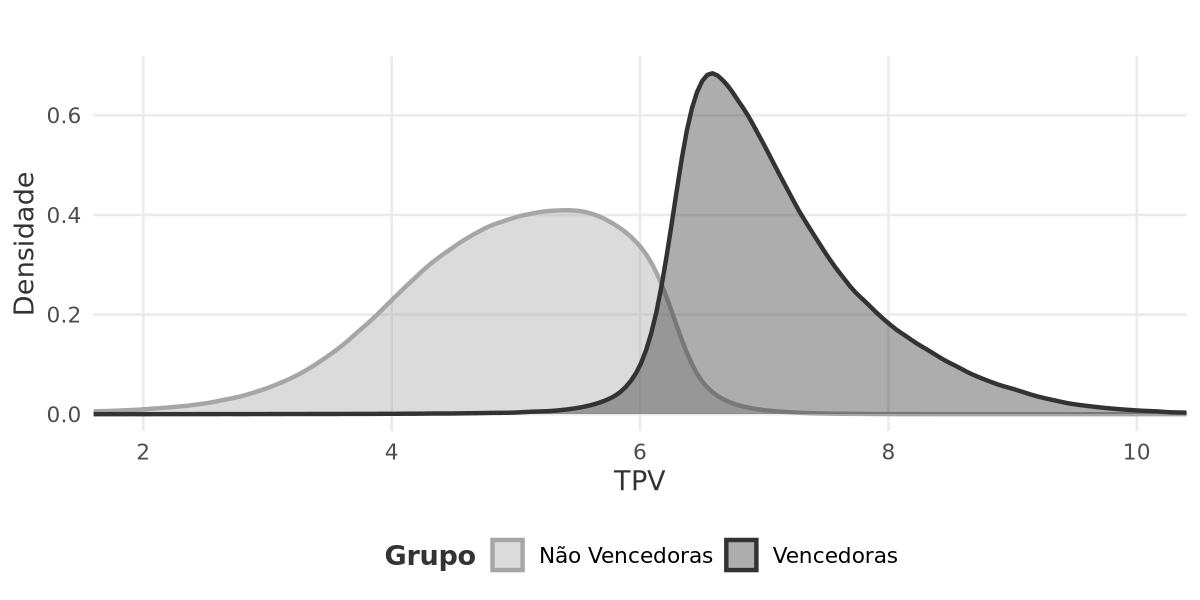

In [49]:
# Recria o data frame combinando as duas bases e renomeando
dados <- rbind(
  data.frame(log_q = base_w$log_q, origem = "Vencedoras"),
  data.frame(log_q = base_l$log_q, origem = "Não Vencedoras")
)

# Gráfico
ggplot(dados, aes(x = log_q, color = origem, fill = origem)) +
  geom_density(alpha = 0.4, adjust = 1.1, linewidth = 1) +
  scale_color_manual(values = c("Vencedoras" = "gray20", "Não Vencedoras" = "gray65")) +
  scale_fill_manual(values  = c("Vencedoras" = "gray20", "Não Vencedoras" = "gray65")) +
  coord_cartesian(xlim = c(2, 10)) +  # restringe o eixo X sem descartar dados
    labs(
    title = "",
    x = "TPV",
    y = "Densidade",
    color = "Grupo",
    fill  = "Grupo"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, color = "gray15"),
    axis.title  = element_text(color = "gray20"),
    axis.text   = element_text(color = "gray30"),
    legend.position = "bottom",
    legend.title = element_text(face = "bold", color = "gray20"),
    panel.grid.minor = element_blank()
  )


In [ ]:
write_csv(base_w,'base_w_V2.csv')

In [56]:
length(unique(base_modelo$document))

[1] 462808

In [59]:
base_modelo_desc = base_modelo %>% distinct(document) %>% ungroup() %>% mutate(cadastro_stone = if_else(document %in% ls_doc_cadastro_stone,1,0),
                              cadastro_ton = if_else(document %in% ls_doc_cadastro_ton,1,0),
                              ativo_30d_stone = if_else(document %in% ls_doc_ativos_stone,1,0),
                               ativo_30d_ton = if_else(document %in% ls_doc_ativos_ton,1,0))

In [60]:
base_modelo_desc %>% filter((cadastro_stone == 1) | (cadastro_ton == 1)) %>% nrow(.)

[1] 300683

In [61]:
base_modelo_desc %>% filter(cadastro_stone == 0,cadastro_ton == 0) %>% nrow(.)

[1] 162125

In [62]:
base_modelo_desc %>% filter(cadastro_stone == 1,cadastro_ton == 0) %>% nrow(.)

[1] 248656

In [63]:
base_modelo_desc %>% filter(cadastro_stone == 0,cadastro_ton == 1) %>% nrow(.)

[1] 17158

In [64]:
base_modelo_desc %>% filter(cadastro_stone == 1,cadastro_ton == 1) %>% nrow(.)

[1] 34869

In [65]:
base_modelo_desc %>% filter((ativo_30d_stone == 1)|(ativo_30d_ton == 1)) %>% nrow(.)

[1] 170540

In [66]:
base_modelo_desc %>% filter(ativo_30d_stone == 0,ativo_30d_ton == 0) %>% nrow(.)

[1] 292268

In [67]:
base_modelo_desc %>% filter(ativo_30d_stone == 1,ativo_30d_ton == 0) %>% nrow(.)

[1] 152295

In [68]:
base_modelo_desc %>% filter(ativo_30d_stone == 0,ativo_30d_ton == 1) %>% nrow(.)

[1] 17407

In [69]:
base_modelo_desc %>% filter(ativo_30d_stone == 1,ativo_30d_ton == 1) %>% nrow(.)

[1] 838

In [ ]:
base_w_ = base_w %>% distinct(document)

In [ ]:
base_w_desc = base_w_ %>% ungroup() %>% mutate(cadastro_stone = if_else(document %in% ls_doc_cadastro_stone,1,0),
                              cadastro_ton = if_else(document %in% ls_doc_cadastro_ton,1,0),
                              ativo_30d_stone = if_else(document %in% ls_doc_ativos_stone,1,0),
                               ativo_30d_ton = if_else(document %in% ls_doc_ativos_ton,1,0))

In [ ]:
base_w_desc %>% filter((cadastro_stone == 1) | (cadastro_ton == 1)) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(cadastro_stone == 0,cadastro_ton == 0) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(cadastro_stone == 1,cadastro_ton == 0) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(cadastro_stone == 0,cadastro_ton == 1) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(cadastro_stone == 1,cadastro_ton == 1) %>% nrow(.)

In [ ]:
base_w_desc %>% filter((ativo_30d_stone == 1)|(ativo_30d_ton == 1)) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(ativo_30d_stone == 0,ativo_30d_ton == 0) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(ativo_30d_stone == 1,ativo_30d_ton == 0) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(ativo_30d_stone == 0,ativo_30d_ton == 1) %>% nrow(.)

In [ ]:
base_w_desc %>% filter(ativo_30d_stone == 1,ativo_30d_ton == 1) %>% nrow(.)

In [ ]:
base_w_desc_join = base_w %>% left_join(.,base_w_desc,by=c("document"))

In [ ]:
write_csv(base_w_desc_join,'base_w_desc.csv')

In [ ]:
base_l_desc = base_l %>% distinct(document) %>% ungroup() %>% mutate(cadastro_stone = if_else(document %in% ls_doc_cadastro_stone,1,0),
                              cadastro_ton = if_else(document %in% ls_doc_cadastro_ton,1,0),
                              ativo_30d_stone = if_else(document %in% ls_doc_ativos_stone,1,0),
                               ativo_30d_ton = if_else(document %in% ls_doc_ativos_ton,1,0))

In [ ]:
base_l_desc_join = base_l %>% left_join(.,base_l_desc,by=c("document"))

In [ ]:
write_csv(base_l_desc_join,'base_l_desc.csv')

In [ ]:
seq(0,1,.1)

In [ ]:
as.numeric(quantile(base_modelo_$med_faturamento, probs = seq(0.1,1,.1)))

In [ ]:
quantile(base_l$med_faturamento)

In [ ]:
as.numeric(quantile(base_l$med_faturamento,0.99))

In [ ]:
# Define grid comum
x_seq <- seq(0, 15, length.out = 1000)

dens_w <- density(base_w$med_faturamento, from = 0, to = 15, n = 1000, na.rm = TRUE)
dens_l <- density(base_l$med_faturamento, from = 0, to = 15, n = 1000, na.rm = TRUE)

# Interpola as densidades no mesmo eixo
y_w <- approx(dens_w$x, dens_w$y, xout = x_seq, yleft = 0, yright = 0)$y
y_l <- approx(dens_l$x, dens_l$y, xout = x_seq, yleft = 0, yright = 0)$y

# Proporção de overlap em cada ponto (mínimo relativo)
prop_overlap <- pmin(y_w, y_l) / pmax(y_w, y_l)
prop_overlap[is.na(prop_overlap)] <- 0  # evita NAs

df_overlap <- data.frame(
  x = x_seq,
  dens_w = y_w,
  dens_l = y_l,
  prop_overlap = prop_overlap
)

ggplot(df_overlap, aes(x = x)) +
  geom_area(aes(y = prop_overlap), fill = "gray60", alpha = 0.6) +
  labs(
    title = "Proporção de Overlapping entre Vencedoras e Não Vencedoras",
    x = "med_faturamento",
    y = "Proporção de Overlap"
  ) +
  coord_cartesian(xlim = c(5, 15), ylim = c(0, 1)) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5, color = "gray20"),
    axis.title  = element_text(color = "gray30"),
    axis.text   = element_text(color = "gray40")
  )


In [ ]:
# Considerando decil do faturamento
doc_q1 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.1))) %>% pull(document) 
doc_q2 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.1)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.2))) %>% pull(document) 
doc_q3 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.2)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.3))) %>% pull(document) 
doc_q4 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.3)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.4))) %>% pull(document) 
doc_q5 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.4)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.5))) %>% pull(document) 
doc_q6 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.5)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.6))) %>% pull(document) 
doc_q7 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.6)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.7))) %>% pull(document) 
doc_q8 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.7)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.8))) %>% pull(document) 
doc_q9 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.8)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.9))) %>% pull(document) 
doc_q10 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0.9)),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 1))) %>% pull(document) 


In [ ]:
# Considerando corte de faturamento Stone
doc_1 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0)),med_faturamento <= log(7000)) %>% pull(document) 
doc_2 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(7000),med_faturamento <= log(15000)) %>% pull(document) 
doc_3 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(15000),med_faturamento <= log(30000)) %>% pull(document) 
doc_4 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(30000),med_faturamento <= log(50000)) %>% pull(document) 
doc_5 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(50000),med_faturamento <= log(100000)) %>% pull(document) 
doc_6 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(100000),med_faturamento <= log(2000000)) %>% pull(document) 
doc_7 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(2000000),med_faturamento <= log(50000000)) %>% pull(document) 
doc_8 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(50000000),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 1))) %>% pull(document) 


In [ ]:
# Considerando um corte de faturamento arbitrário
doc_1 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > as.numeric(quantile(base_modelo_$med_faturamento, probs = 0)),med_faturamento <= log(10000)) %>% pull(document) 
doc_2 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(10000),med_faturamento <= log(25000)) %>% pull(document) 
doc_3 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(25000),med_faturamento <= log(50000)) %>% pull(document) 
doc_4 = base_modelo_ %>% ungroup() %>% filter(med_faturamento > log(50000),med_faturamento <= as.numeric(quantile(base_modelo_$med_faturamento, probs = 1))) %>% pull(document) 


In [ ]:
base_l_q1 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q1)
base_w_q1 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q1)

base_l_q2 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q2)
base_w_q2 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q2)

base_l_q3 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q3)
base_w_q3 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q3)

base_l_q4 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q4)
base_w_q4 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q4)

base_l_q5 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q5)
base_w_q5 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q5)

base_l_q6 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q6)
base_w_q6 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q6)

base_l_q7 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q7)
base_w_q7 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q7)

base_l_q8 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q8)
base_w_q8 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q8)

base_l_q9 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q9)
base_w_q9 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q9)

base_l_q10 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_q10)
base_w_q10 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_q10)


In [ ]:
base_l_1 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_1)
base_w_1 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_1)

base_l_2 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_2)
base_w_2 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_2)

base_l_3 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_3)
base_w_3 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_3)

base_l_4 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_4)
base_w_4 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_4)

base_l_5 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_5)
base_w_5 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_5)

base_l_6 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_6)
base_w_6 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_6)

base_l_7 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_7)
base_w_7 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_7)

base_l_8 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_8)
base_w_8 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_8)



In [ ]:
base_l_1 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_1)
base_w_1 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_1)

base_l_2 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_2)
base_w_2 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_2)

base_l_3 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_3)
base_w_3 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_3)

base_l_4 = base_l_desc_join %>% ungroup() %>% filter(document %in% doc_4)
base_w_4 = base_w_desc_join %>% ungroup() %>% filter(document %in% doc_4)


In [ ]:
base_q1 = rbind(base_w_q1,base_l_q1)
base_q2 = rbind(base_w_q2,base_l_q2)
base_q3 = rbind(base_w_q3,base_l_q3)
base_q4 = rbind(base_w_q4,base_l_q4)
base_q5 = rbind(base_w_q5,base_l_q5)
base_q6 = rbind(base_w_q6,base_l_q6)
base_q7 = rbind(base_w_q7,base_l_q7)
base_q8 = rbind(base_w_q8,base_l_q8)
base_q9 = rbind(base_w_q9,base_l_q9)
base_q10 = rbind(base_w_q10,base_l_q10)

In [ ]:
base_1 = rbind(base_w_1,base_l_1)
base_2 = rbind(base_w_2,base_l_2)
base_3 = rbind(base_w_3,base_l_3)
base_4 = rbind(base_w_4,base_l_4)
base_5 = rbind(base_w_5,base_l_5)
base_6 = rbind(base_w_6,base_l_6)
base_7 = rbind(base_w_7,base_l_7)
base_8 = rbind(base_w_8,base_l_8)


In [ ]:
base_1 = rbind(base_w_1,base_l_1)
base_2 = rbind(base_w_2,base_l_2)
base_3 = rbind(base_w_3,base_l_3)
base_4 = rbind(base_w_4,base_l_4)


In [ ]:
write_csv(base_q1,'base_q1.csv')
write_csv(base_q2,'base_q2.csv')
write_csv(base_q3,'base_q3.csv')
write_csv(base_q4,'base_q4.csv')
write_csv(base_q5,'base_q5.csv')
write_csv(base_q6,'base_q6.csv')
write_csv(base_q7,'base_q7.csv')
write_csv(base_q8,'base_q8.csv')
write_csv(base_q9,'base_q9.csv')
write_csv(base_q10,'base_q10.csv')

In [ ]:
write_csv(base_1,'base_1.csv')
write_csv(base_2,'base_2.csv')
write_csv(base_3,'base_3.csv')
write_csv(base_4,'base_4.csv')
write_csv(base_5,'base_5.csv')
write_csv(base_6,'base_6.csv')
write_csv(base_7,'base_7.csv')
write_csv(base_8,'base_8.csv')

In [ ]:
write_csv(base_1,'base_1.csv')
write_csv(base_2,'base_2.csv')
write_csv(base_3,'base_3.csv')
write_csv(base_4,'base_4.csv')